In [1]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds
import delfi.kernel as dk

from delfi.simulator.BaseSimulator import BaseSimulator

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from delfi.utils.viz import plot_pdf

from tqdm import tqdm_notebook as tqdm

from parameters import ParameterSet

%matplotlib notebook

from delfi.utils.viz import plot_pdf, plot_hist_marginals

In [2]:
class ShapeModel(BaseSimulator):
    def __init__(self, f, sigma, ndim, seed=None):
        super().__init__(dim_param=ndim, seed=seed)
        self.f = f
        
        self.sigma = sigma
        
    def gen_single(self, params):
        m = self.f(params)
        draw = self.rng.normal(loc=m, scale=self.sigma, size=(1,))
        return { 'data' : draw }
    
class ShapeDistribution(dd.BaseDistribution.BaseDistribution):
    def __init__(self, f, sm, obs_stats, seed=None):
        super().__init__(sm.dim_param, seed=seed)
        self.f = f
        self.sm = sm
        self.obs_stats = obs_stats
        self.m = np.linalg.norm(obs_stats)
        self.sigma = sm.sigma
        
    def eval(self, params, log=True):
        logl = -0.5 * np.log(2 * np.pi * self.sigma) -0.5 * ([self.f(param) for param in params] - self.m) ** 2 / (self.sigma ** 2)
        return logl if log else np.exp(logl)

In [3]:
class ModelConcat(BaseSimulator):
    def __init__(self, mlist, seed=None):
        dim_params = [ m.dim_param for m in mlist ]
        super().__init__(dim_param=np.sum(dim_params), seed=seed)
        
        self.mlist = mlist
        self.idx_list = np.insert(np.cumsum(dim_params), 0, 0)
        
    def gen_single(self, params):
        params_list = [ params[self.idx_list[i]:self.idx_list[i+1]] for i in range(len(self.mlist)) ]
        rets = [ m.gen_single(p) for m, p in zip(self.mlist, params_list) ]
        
        data_ret = np.concatenate([ r['data'] for r in rets ])
        return { 'data' : data_ret }

In [4]:
def plot_pdf_2d(params, dist, label = None):
    lims = 2 * np.linalg.norm(params.obs_stats)
    xlist = np.linspace(-lims, lims, 80)
    ylist = np.linspace(-lims, lims, 80)
    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111, projection='3d')
    
    X, Y = np.meshgrid(xlist, ylist)
    xys = np.asarray((X.ravel(), Y.ravel())).T
    
    if label is not None:
        fig.suptitle(label)
        
    Z = dist.eval(xys, log=False).reshape(X.shape)
    ax.plot_surface(X, Y, Z, cmap=cm.plasma, rstride=1, cstride=1, linewidth=0, antialiased=False)
        
    ax.set_xlabel("$\\theta_1$")
    ax.set_ylabel("$\\theta_2$")
    ax.set_zlabel("$p(\\theta)$")
    plt.show()
    
    return fig

In [18]:
def run_SNPE(params):
    seeds = np.arange(0, params.n_copies) + params.seed 
    mlist = [ ShapeModel(params.f, sigma=params.sigma, ndim=params.ndim, seed=s) for s in seeds ]
    mc = ModelConcat(mlist, seed=params.seed)
    m = mlist[0]
    p = dd.Uniform(-params.prior_width * np.ones(params.n_copies * params.ndim), params.prior_width * np.ones(params.n_copies * params.ndim), seed=params.seed)
    s = ds.Identity(params.n_copies)
    g = dg.Default(model=mc, prior=p, summary=s)
    
    res = infer.SNPE(g, obs=[params.obs_stats], 
                     n_hiddens=params.n_hiddens, 
                     n_components=params.n_components, 
                     seed=params.seed, 
                     prior_mixin=params.prior_mixin, 
                     kernel=params.kernel,
                     convert_to_T=params.convert_to_T,
                     svi=False,
                     verbose=True)
    
    logs, tds, posteriors = res.run(n_train=params.n_train, n_rounds = params.n_rounds, stop_on_nan=True, round_cl=params.round_cl, es_thresh=0.001)

    return mc, p, s, res, posteriors, logs, tds

In [25]:
default_params = ParameterSet({})

#was 394,395 for good result
default_params.seed = 396
default_params.ndim = 2
default_params.n_components = 40
default_params.n_hiddens = 2 * [ default_params.n_components * default_params.ndim * 4 ]

default_params.sigma = 0.2

default_params.n_copies = 4

default_params.true_params = np.tile(2 * np.eye(default_params.ndim)[0], default_params.n_copies)
default_params.obs_stats = np.zeros(default_params.n_copies)
default_params.prior_width = 2

default_params.prior_mixin= 0.0
default_params.convert_to_T = 1
default_params.round_cl = 10

default_params.kernel = None

default_params.n_train = 150000
default_params.n_rounds = 3

cubic = lambda x: (x[0] - 2) * (x[0] + 2) * x[0] - x[1]
ushape = lambda x: x[0] ** 2 - x[1] - 1
ring = lambda x: np.linalg.norm(x) - 1
default_params.f = ring

In [26]:
std_params = default_params

m, p, s, res, posteriors, logs, tds = run_SNPE(std_params)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

<IPython.core.display.Javascript object>


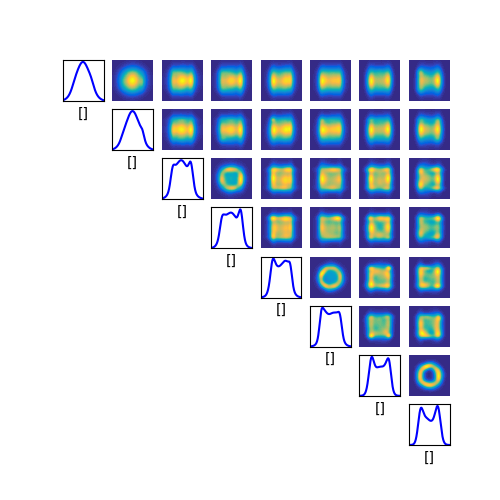

<IPython.core.display.Javascript object>


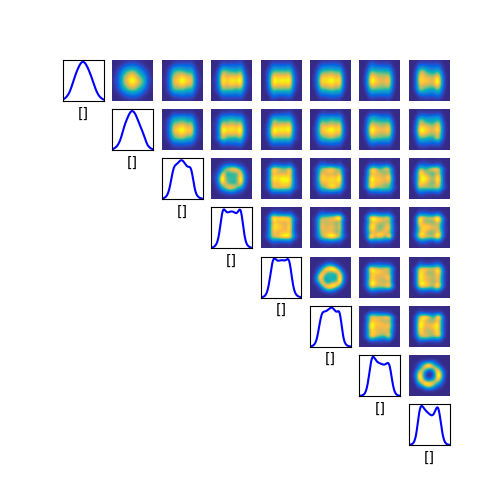

<IPython.core.display.Javascript object>


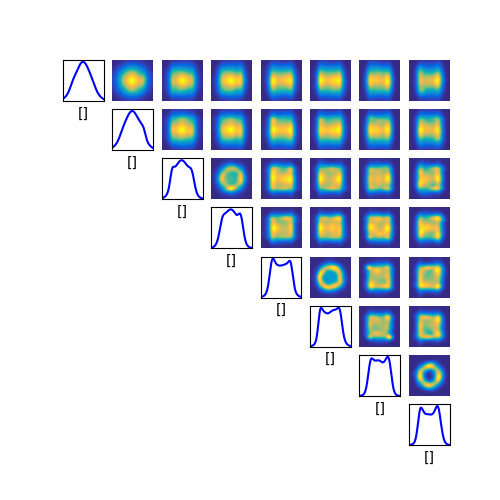

In [27]:
for posterior in posteriors:
    if posterior is None:
        continue
        
    fig, _ = plot_pdf(posterior,  lims=[-default_params.prior_width, default_params.prior_width])

In [ ]:
seeds = default_params.seed + np.arange(default_params.n_copies)
gts = [ ShapeDistribution(default_params.f, m.mlist[0], default_params.obs_stats, seed=s) for s in seeds ]
gt = dd.MixedDistribution(gts, seed=default_params.seed)
    

In [ ]:
def mcmc(start, pdf, var=0.1, nsamples=200000):
    ndim = len(start)
    S = np.eye(ndim) * var
    mu_current = start
    l_current = pdf.eval([mu_current], log=False)
    
    samples = np.empty((nsamples, ndim))
    for i in tqdm(range(nsamples)):
        mu_proposal = np.random.multivariate_normal(mean=mu_current, cov=S)

        l_proposal = pdf.eval([mu_proposal], log=False)
        p_accept = l_proposal / l_current
        accept = np.random.rand() < p_accept
        
        if accept:
            mu_current = mu_proposal
            l_current = l_proposal
        
        samples[i,:] = mu_current
        
    return samples

start = np.zeros_like(default_params.true_params)

gt.eval([start])
samples = mcmc(start, pdf=gt)

In [ ]:

fig, _ = plot_pdf(pdf1=posterior, samples=samples.T, lims=[-default_params.prior_width, default_params.prior_width])